#Data

In [1]:
pip install kaggle 

In [ ]:
#upload your kaggle key (if in google colab , if not just ignore/delete this cell)
from google.colab import files
files.upload()

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d sid321axn/audit-data

In [5]:
!unzip audit-data.zip

Archive:  audit-data.zip
  inflating: audit_data.csv          
  inflating: trial.csv               


#EDA

In [171]:
import pandas as pd 
df = pd.read_csv("audit_data.csv")
df.head()

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,Score_B.1,Risk_C,Money_Value,Score_MV,Risk_D,District_Loss,PROB,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
0,3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5.0,0.2,1.0,3.38,0.2,0.676,2,0.2,0.4,0,0.2,0.0,2.4,8.574,0.4,0.5,1.7148,1
1,3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5.0,0.2,1.0,0.94,0.2,0.188,2,0.2,0.4,0,0.2,0.0,2.0,2.554,0.4,0.5,0.5108,0
2,3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5.0,0.2,1.0,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0.0,2.0,1.548,0.4,0.5,0.3096,0
3,3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6.0,0.6,3.6,11.75,0.6,7.050,2,0.2,0.4,0,0.2,0.0,4.4,17.530,0.4,0.5,3.5060,1
4,3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5.0,0.2,1.0,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0.0,2.0,1.416,0.4,0.5,0.2832,0


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sector_score    776 non-null    float64
 1   LOCATION_ID     776 non-null    object 
 2   PARA_A          776 non-null    float64
 3   Score_A         776 non-null    float64
 4   Risk_A          776 non-null    float64
 5   PARA_B          776 non-null    float64
 6   Score_B         776 non-null    float64
 7   Risk_B          776 non-null    float64
 8   TOTAL           776 non-null    float64
 9   numbers         776 non-null    float64
 10  Score_B.1       776 non-null    float64
 11  Risk_C          776 non-null    float64
 12  Money_Value     775 non-null    float64
 13  Score_MV        776 non-null    float64
 14  Risk_D          776 non-null    float64
 15  District_Loss   776 non-null    int64  
 16  PROB            776 non-null    float64
 17  RiSk_E          776 non-null    flo

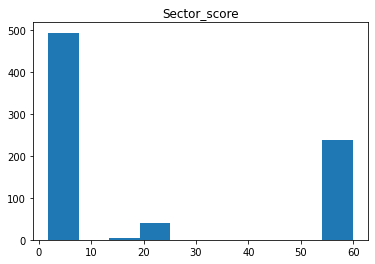

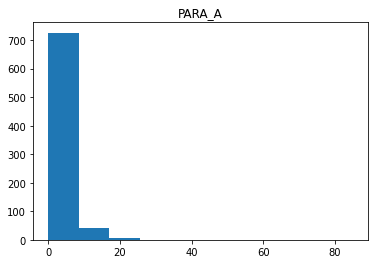

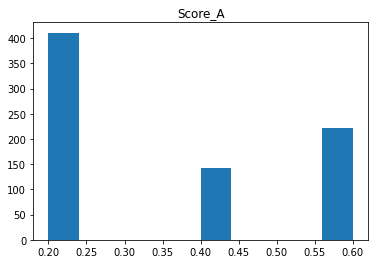

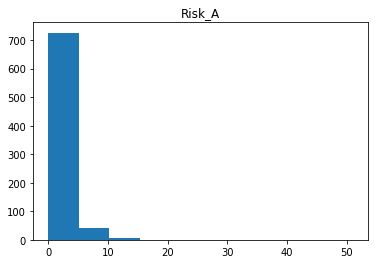

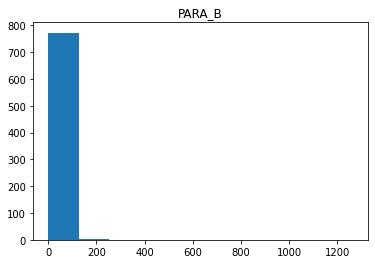

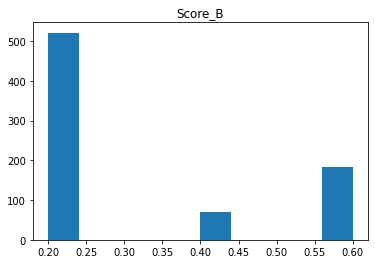

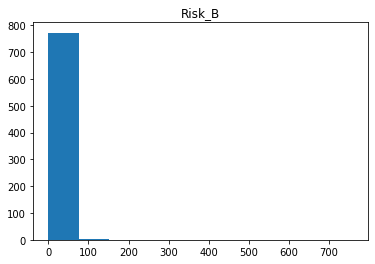

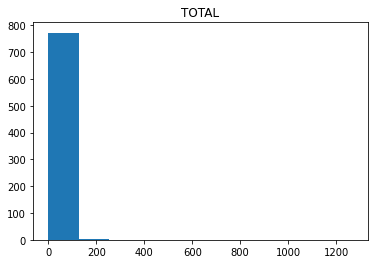

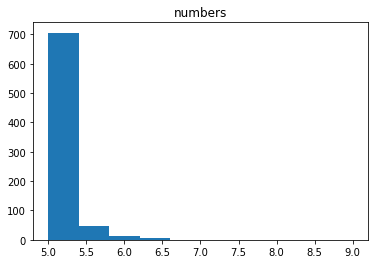

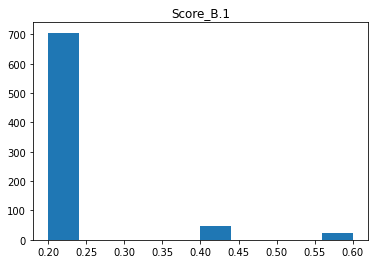

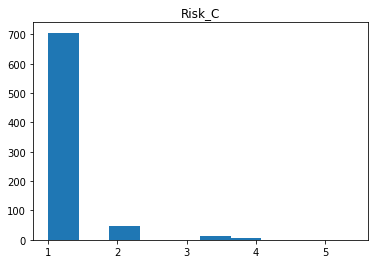

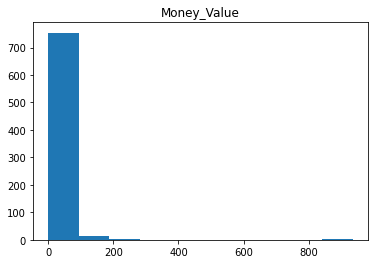

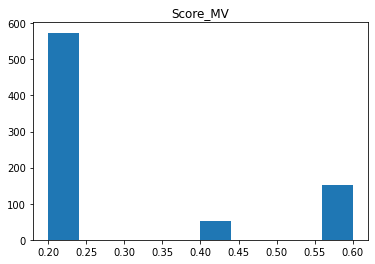

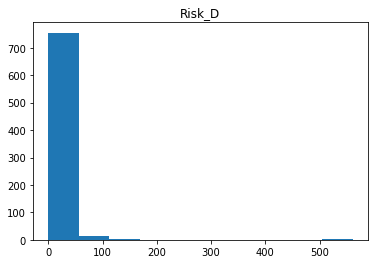

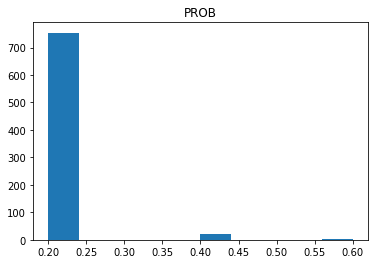

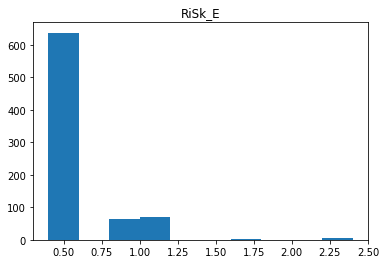

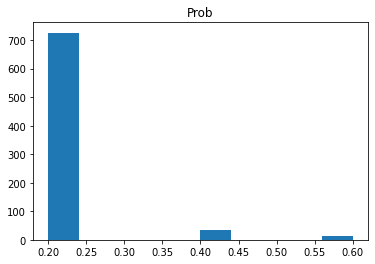

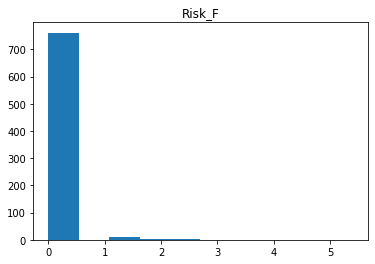

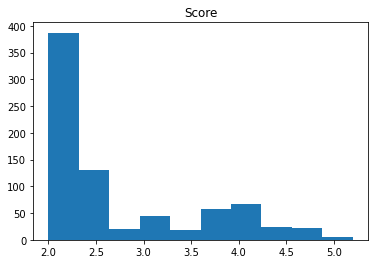

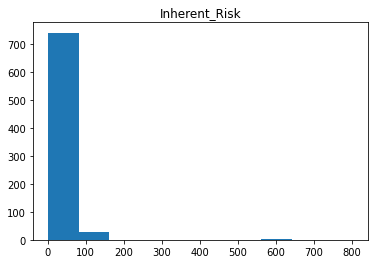

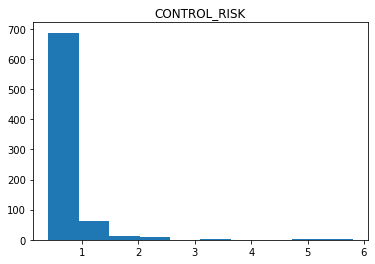

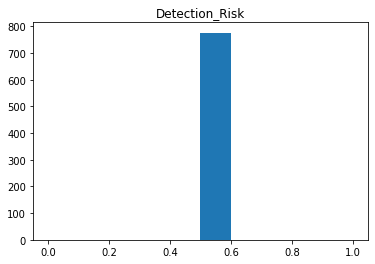

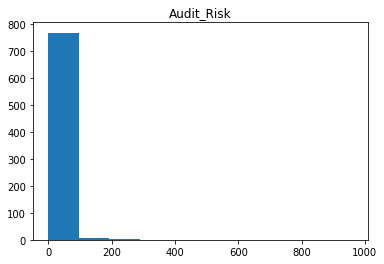

In [109]:
continuous_features = df.select_dtypes(include="float64").columns

import matplotlib.pyplot as plt
import seaborn as sns

for feature in continuous_features:
  plt.figure(figsize=(6,4))
  plt.hist(df[feature])
  plt.title(feature,fontsize=12)
  plt.show()

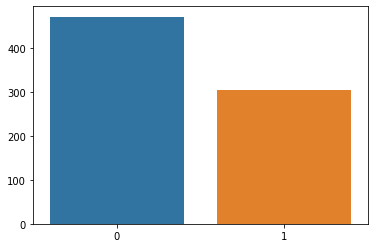

In [110]:
sns.barplot(x=df["Risk"].value_counts().index,y=df["Risk"].value_counts().values)
plt.show()

#engineering/selection

In [ ]:
df.head()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
categorical_feature = df.select_dtype(include="object").columns
df[categorical_feature] = encoder.fit_transform(df[categorical_feature])

df

In [112]:
df.head()

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,Score_B.1,Risk_C,Money_Value,Score_MV,Risk_D,District_Loss,PROB,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
0,3.89,14,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5.0,0.2,1.0,3.38,0.2,0.676,2,0.2,0.4,0,0.2,0.0,2.4,8.574,0.4,0.5,1.7148,1
1,3.89,38,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5.0,0.2,1.0,0.94,0.2,0.188,2,0.2,0.4,0,0.2,0.0,2.0,2.554,0.4,0.5,0.5108,0
2,3.89,38,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5.0,0.2,1.0,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0.0,2.0,1.548,0.4,0.5,0.3096,0
3,3.89,38,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6.0,0.6,3.6,11.75,0.6,7.050,2,0.2,0.4,0,0.2,0.0,4.4,17.530,0.4,0.5,3.5060,1
4,3.89,38,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5.0,0.2,1.0,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0.0,2.0,1.416,0.4,0.5,0.2832,0


In [177]:
df.isnull().sum()

Sector_score      0
LOCATION_ID       0
PARA_A            0
Score_A           0
Risk_A            0
PARA_B            0
Score_B           0
Risk_B            0
TOTAL             0
numbers           0
Score_B.1         0
Risk_C            0
Money_Value       1
Score_MV          0
Risk_D            0
District_Loss     0
PROB              0
RiSk_E            0
History           0
Prob              0
Risk_F            0
Score             0
Inherent_Risk     0
CONTROL_RISK      0
Detection_Risk    0
Audit_Risk        0
Risk              0
dtype: int64

In [114]:
df[df["Money_Value"].isnull()]

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,Score_B.1,Risk_C,Money_Value,Score_MV,Risk_D,District_Loss,PROB,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
642,55.57,31,0.23,0.2,0.046,0.0,0.2,0.0,0.23,5.0,0.2,1.0,NaN,0.2,0.0,2,0.2,0.4,0,0.2,0.0,2.0,1.446,0.4,0.5,0.2892,0


In [178]:
df.drop(index=642,inplace=True)

In [179]:
from sklearn.model_selection import train_test_split
target = df["Risk"]
df.drop(["Risk"],axis=1,inplace=True)

xtrain,xtest,ytrain,ytest = train_test_split(df,target,test_size=0.2,random_state=0)

In [180]:
from sklearn.feature_selection import SelectKBest,f_classif

best_features = SelectKBest(score_func=f_classif,k=9)
fit = best_features.fit(xtrain,ytrain)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(xtrain.columns)

feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
feature_scores.columns = ["Specs","Score"]

print(feature_scores.nlargest(15,"Score"))

            Specs        Score
21          Score  1084.619459
13       Score_MV   563.710009
6         Score_B   474.046682
3         Score_A   389.826831
8           TOTAL   257.772856
5          PARA_B   215.808086
7          Risk_B   209.610344
0    Sector_score   131.889272
22  Inherent_Risk   126.480669
25     Audit_Risk   119.749357
17         RiSk_E   118.897593
23   CONTROL_RISK   117.142722
15  District_Loss   113.867908
4          Risk_A   107.027268
2          PARA_A   102.951300


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [24] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


#Quick modelling

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Model structures
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, r2_score

In [182]:
rf_pipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",RandomForestClassifier(random_state=0)) ])

rf_scores = cross_val_score(rf_pipe,xtrain,ytrain,cv=5,scoring='roc_auc')

In [183]:
print('Rndmforest validation score: ', rf_scores.max())

Rndmforest validation score:  1.0


In [121]:
rf_pipe.fit(xtrain,ytrain)
predictions = rf_pipe.predict(xtest)

acc = accuracy_score(ytest,predictions)
r2 = r2_score(ytest,predictions)
print(f"accuracy: {acc} , r2_score: {r2}")

print(confusion_matrix(ytest,predictions))

accuracy: 1.0 , r2_score: 1.0
[[89  0]
 [ 0 66]]


#Config

In [197]:
df = pd.read_csv("audit_data.csv")
df.head()

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,Score_B.1,Risk_C,Money_Value,Score_MV,Risk_D,District_Loss,PROB,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
0,3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5.0,0.2,1.0,3.38,0.2,0.676,2,0.2,0.4,0,0.2,0.0,2.4,8.574,0.4,0.5,1.7148,1
1,3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5.0,0.2,1.0,0.94,0.2,0.188,2,0.2,0.4,0,0.2,0.0,2.0,2.554,0.4,0.5,0.5108,0
2,3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5.0,0.2,1.0,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0.0,2.0,1.548,0.4,0.5,0.3096,0
3,3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6.0,0.6,3.6,11.75,0.6,7.050,2,0.2,0.4,0,0.2,0.0,4.4,17.530,0.4,0.5,3.5060,1
4,3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5.0,0.2,1.0,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0.0,2.0,1.416,0.4,0.5,0.2832,0


In [189]:
SELECTED_FEATURES = ['Sector_score', 'PARA_A', 'Score_A', 'Risk_A', 'PARA_B', 'Score_B',
       'Risk_B', 'TOTAL', 'numbers', 'Score_B.1', 'Risk_C', 'Money_Value',
       'Score_MV', 'Risk_D', 'District_Loss', 'PROB', 'RiSk_E', 'History',
       'Prob', 'Risk_F', 'Score', 'Inherent_Risk', 'CONTROL_RISK',
       'Detection_Risk', 'Audit_Risk','LOCATION_ID']

CATEGORICAL_FEATURE = 'LOCATION_ID'

NUMERICAL_FEATURES = ['Sector_score', 'PARA_A', 'Score_A', 'Risk_A', 'PARA_B', 'Score_B',
       'Risk_B', 'TOTAL', 'numbers', 'Score_B.1', 'Risk_C', 'Money_Value',
       'Score_MV', 'Risk_D', 'District_Loss', 'PROB', 'RiSk_E', 'History',
       'Prob', 'Risk_F', 'Score', 'Inherent_Risk', 'CONTROL_RISK',
       'Detection_Risk', 'Audit_Risk']

NA_INDEX = 642


VARIABLE_DROP_NA = 'Money_Value'

TARGET = 'Risk'

In [196]:
df[SELECTED_FEATURES]

,Sector_score,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,Score_B.1,Risk_C,Money_Value,Score_MV,Risk_D,District_Loss,PROB,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,LOCATION_ID
0,3.89,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5.0,0.2,1.0,3.38,0.2,0.676,2,0.2,0.4,0,0.2,0.0,2.4,8.574,0.4,0.5,1.7148,23
1,3.89,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5.0,0.2,1.0,0.94,0.2,0.188,2,0.2,0.4,0,0.2,0.0,2.0,2.554,0.4,0.5,0.5108,6
2,3.89,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5.0,0.2,1.0,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0.0,2.0,1.548,0.4,0.5,0.3096,6
3,3.89,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6.0,0.6,3.6,11.75,0.6,7.050,2,0.2,0.4,0,0.2,0.0,4.4,17.530,0.4,0.5,3.5060,6
4,3.89,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5.0,0.2,1.0,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0.0,2.0,1.416,0.4,0.5,0.2832,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,55.57,0.49,0.2,0.098,0.40,0.2,0.080,0.89,5.0,0.2,1.0,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0.0,2.0,1.578,0.4,0.5,0.3156,9
772,55.57,0.47,0.2,0.094,0.37,0.2,0.074,0.84,5.0,0.2,1.0,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0.0,2.0,1.568,0.4,0.5,0.3136,16
773,55.57,0.24,0.2,0.048,0.04,0.2,0.008,0.28,5.0,0.2,1.0,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0.0,2.0,1.456,0.4,0.5,0.2912,14
774,55.57,0.20,0.2,0.040,0.00,0.2,0.000,0.20,5.0,0.2,1.0,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0.0,2.0,1.440,0.4,0.5,0.2880,18


#Pipeline

##Transformers

In [190]:
from sklearn.base import BaseEstimator,TransformerMixin

class RareLabelEncoder(BaseEstimator,TransformerMixin):
  def __init__(self,categorical_features,tol_rate):
    if not isinstance(categorical_features,list):
      self.categorical_features = [categorical_features]
    else:
      self.categorical_features = categorical_features

    self.tol_rate = tol_rate
    self.frequent_labels = {}
    
  def fit(self,X,y=None):
    for feature in self.categorical_features:
      #gets a list of labels that appear more frequently than the tol rate
      higher_than_tol_rate = (X[feature].value_counts() / len(X)) > self.tol_rate
      frequent_labels = list(X[feature].value_counts()[higher_than_tol_rate].index)

      #attributes a list of the most frequent labels for each feature
      self.frequent_labels[feature] = frequent_labels
    return self

  def transform(self,X):
    X = X.copy()
    for feature in self.categorical_features:
      X[feature] = np.where(X[feature].isin(self.frequent_labels[feature]),X[feature],"Rare")
    return X

class CategoricalImputer(BaseEstimator,TransformerMixin):
  def __init__(self,categorical_features):
    if not isinstance(categorical_features,list):
      self.categorical_features = [categorical_features]
    else:
      self.categorical_features = categorical_features

  def fit(self,X,y=None):
    from sklearn.preprocessing import OrdinalEncoder 
    self.encoder = OrdinalEncoder()
    self.encoder.fit(X[self.categorical_features])
    return self

  def transform(self,X):
    X = X.copy()
    X[self.categorical_features] = self.encoder.transform(X[self.categorical_features])
    return X

##pipeline

In [191]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
          ("impute rare labels",RareLabelEncoder(CATEGORICAL_FEATURE,tol_rate=0.01)),
          ("categorical imputer",CategoricalImputer(CATEGORICAL_FEATURE)),
          ("scaler",StandardScaler()),
          ("model",RandomForestClassifier(random_state=0))
])

In [186]:
df = pd.read_csv("audit_data.csv")

In [192]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix

df.drop(index=NA_INDEX,inplace=True)
xtrain,xtest,ytrain,ytest = train_test_split(df[SELECTED_FEATURES],df[TARGET],test_size=0.2,random_state=0)

pipeline.fit(xtrain,ytrain)
pred = pipeline.predict(xtest)
print(confusion_matrix(ytest,pred))

[[89  0]
 [ 0 66]]
